In [1]:
# 2022/01/05 업데이트 내용:
# 건물연식 2년이하 자료들도 생성

In [2]:
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['font.family'] = 'Malgun Gothic'
import datetime

In [3]:
target_gu = '강동구' # 구 명
target_dong = '암사' # 동 명: 동 명에서 마지막 글자 '동' 뺄 것
#target_purpose = '준주거' # 종 명: 건드릴 필요 없음
target_building_age = 5 # 건물연식: 건드릴 필요 없음
target_period = 36 # 계약날짜 검색범위: 건드릴 필요 없음
target_starting_year = 2018 # 검색 시작 계약 년도: 건드릴 필요 없음

In [4]:
date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')

In [5]:
date_today_record = str(date_today).split(' ')[0].replace('-', '')
date_today_record

'20220106'

In [6]:
def day_modifier(x):
    # x is a number
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x)
        if len(x) == 1:
            return '0' + x
        else:
            return x

In [7]:
def landnum_modifier(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x).replace('외', '').replace(' ','')
        splitted = x.split('-')
        if len(splitted) == 1:
            return x + '-0'
        else:
            return x

In [8]:
def data_prep(bdtype, tradetype, starting_year=2018):
    # bdtype is a string: one of 아파트, 연립다세대 or 오피스텔
    # tradetype is a string: one of 매매 or 전월세
    if (tradetype != '매매') & (tradetype != '전월세'):
        raise ValueError('두번째 변수는 매매 또는 전월세만 입력 가능')
    
    
    basedir = './국토교통부_실거래가_공개시스템/{}/{}/'.format(bdtype, tradetype)
    filenames = [f for f in os.listdir(basedir) if (f.endswith('.csv'))&('(' in f)]
    
    dfs_list = []
    for i, f in tqdm(enumerate(filenames)):
        splitted_filename = f.split('실거래가_')       
        file_year = int(splitted_filename[-1][:4])
        
        if file_year < starting_year:
            continue
        
        try:
            df = pd.read_csv(basedir + f, encoding='euc-kr', header=15)
        except:
            try:
                df = pd.read_csv(basedir + f, encoding='utf-8', header=15)
            except:
                df = pd.read_csv(basedir + f, header=15)
        
        if '건물명' in df.columns:
            df.rename(columns={'건물명':'건물(단지)명'}, inplace=True)
        elif '단지명' in df.columns:
            df.rename(columns={'단지명':'건물(단지)명'}, inplace=True)
            
        if '대지권면적(㎡)' in df.columns:
            df = df.drop(columns=['대지권면적(㎡)'])
                
            
        if '해제사유발생일' in df.columns.tolist():
            df = df[df['해제사유발생일'].isna()]
            df = df.drop(columns=['해제사유발생일'])
            
        dfs_list.append(df)
    
    concat_df = pd.concat(dfs_list).reset_index(drop=True)
    
    if tradetype == '전월세':
        concat_df = concat_df.rename(columns={'전월세구분':'거래구분', '보증금(만원)':'거래금액(만원)'})
        concat_df = concat_df.drop(columns=['월세(만원)'])
        concat_df = concat_df[concat_df['거래구분'] == '전세']
    elif tradetype == '매매':
        concat_df['거래구분'] = '매매'
        
    concat_df['번지'] = concat_df['번지'].apply(landnum_modifier)
    
    concat_df['계약년월'] = concat_df['계약년월'].astype('Int64')
    concat_df['계약일'] = concat_df['계약일'].astype('Int64')
    
    concat_df['계약년월'] = concat_df['계약년월'].apply(str)
    concat_df['계약일'] = concat_df['계약일'].apply(str)
    
    concat_df['계약날짜기준_건물연식'] = concat_df['계약년월'].apply(lambda x: int(x[:4])) - concat_df['건축년도']
    
    concat_df['계약일'] = concat_df['계약일'].apply(day_modifier)
    
    concat_df['계약날짜'] = concat_df['계약년월'].apply(lambda x: x[:4]) + '-' + concat_df['계약년월'].apply(lambda x: x[-2:])\
    + '-' + concat_df['계약일']
    
    concat_df['계약날짜'] = pd.to_datetime(concat_df['계약날짜'], format='%Y-%m-%d')
    
    concat_df['거래금액(만원)'] = concat_df['거래금액(만원)'].apply(lambda x: int(x.replace(',','')))
    concat_df['단가(만원/㎡)'] = concat_df['거래금액(만원)'] / concat_df['전용면적(㎡)']
    
    concat_df['지번주소'] = concat_df['시군구'] + ' ' + concat_df['번지']
        
    cols_to_drop = ['번지', '지번주소', '계약년월', '계약일', '도로명']
        
    concat_df = concat_df[['지번주소', '도로명'] + [col for col in concat_df.columns if col not in cols_to_drop]]
    
    date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')
    concat_df['건물연식'] = date_today.year - concat_df['건축년도']
    
    concat_df = concat_df.dropna(subset=['지번주소'])
    
    concat_df = concat_df[concat_df['층'] >= 0].reset_index(drop=True)
    
    return concat_df

In [9]:
apart_trade_df = data_prep('아파트', '매매')
apart_lease_df = data_prep('아파트', '전월세')
apart_df = pd.concat([apart_trade_df, apart_lease_df]).reset_index(drop=True)
del apart_trade_df, apart_lease_df
apart_df['부동산유형'] = '아파트'
print(apart_df.shape)
apart_df.head()

16it [00:00, 28.06it/s]
8it [00:00, 28.26it/s]c:\users\max6296\ml\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (10,18) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
11it [00:01,  8.48it/s]


(775684, 23)


,지번주소,도로명,시군구,본번,부번,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래유형,중개사소재지,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,계약기간,계약구분,갱신요구권 사용,종전계약 보증금 (만원),종전계약 월세 (만원),부동산유형
0,서울특별시 강남구 개포동 658-1,언주로 3,서울특별시 강남구 개포동,658.0,1.0,개포6차우성아파트1동~8동,79.97,130000,4,1987.0,-,-,매매,31.0,2018-01-03,1625.609604,35.0,NaN,NaN,NaN,NaN,NaN,아파트
1,서울특별시 강남구 개포동 658-1,언주로 3,서울특별시 강남구 개포동,658.0,1.0,개포6차우성아파트1동~8동,79.97,117000,2,1987.0,-,-,매매,31.0,2018-01-08,1463.048643,35.0,NaN,NaN,NaN,NaN,NaN,아파트
2,서울특별시 강남구 개포동 658-1,언주로 3,서울특별시 강남구 개포동,658.0,1.0,개포6차우성아파트1동~8동,79.97,130000,1,1987.0,-,-,매매,31.0,2018-01-11,1625.609604,35.0,NaN,NaN,NaN,NaN,NaN,아파트
3,서울특별시 강남구 개포동 658-1,언주로 3,서울특별시 강남구 개포동,658.0,1.0,개포6차우성아파트1동~8동,79.97,139500,2,1987.0,-,-,매매,31.0,2018-03-19,1744.404152,35.0,NaN,NaN,NaN,NaN,NaN,아파트
4,서울특별시 강남구 개포동 658-1,언주로 3,서울특별시 강남구 개포동,658.0,1.0,개포6차우성아파트1동~8동,54.98,107500,5,1987.0,-,-,매매,31.0,2018-04-05,1955.256457,35.0,NaN,NaN,NaN,NaN,NaN,아파트


In [10]:
yunrip_trade_df = data_prep('연립다세대', '매매')
yunrip_lease_df = data_prep('연립다세대', '전월세')
yunrip_df = pd.concat([yunrip_trade_df, yunrip_lease_df]).reset_index(drop=True)
del yunrip_trade_df, yunrip_lease_df
yunrip_df['부동산유형'] = '연립다세대'
print(yunrip_df.shape)
yunrip_df.head()

16it [00:00, 30.76it/s] 
8it [00:00, 45.70it/s]c:\users\max6296\ml\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
11it [00:00, 13.17it/s]


(465322, 23)


,지번주소,도로명,시군구,본번,부번,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래유형,중개사소재지,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,계약기간,계약구분,갱신요구권 사용,종전계약 보증금 (만원),종전계약 월세 (만원),부동산유형
0,서울특별시 강남구 개포동 1172-2,논현로6길 22-6,서울특별시 강남구 개포동,1172,2,(1172-2),29.95,25000,4,2012.0,-,-,매매,6.0,2018-01-13,834.724541,10.0,NaN,NaN,NaN,NaN,NaN,연립다세대
1,서울특별시 강남구 개포동 1216-4,개포로26길 16,서울특별시 강남구 개포동,1216,4,(1216-4),29.12,25300,4,2012.0,-,-,매매,6.0,2018-10-23,868.818681,10.0,NaN,NaN,NaN,NaN,NaN,연립다세대
2,서울특별시 강남구 개포동 1187-8,논현로8길 17,서울특별시 강남구 개포동,1187,8,1187-8,55.96,45500,4,2015.0,-,-,매매,3.0,2018-01-04,813.080772,7.0,NaN,NaN,NaN,NaN,NaN,연립다세대
3,서울특별시 강남구 개포동 1187-8,논현로8길 17,서울특별시 강남구 개포동,1187,8,1187-8,59.84,51000,3,2015.0,-,-,매매,3.0,2018-03-09,852.272727,7.0,NaN,NaN,NaN,NaN,NaN,연립다세대
4,서울특별시 강남구 개포동 1187-8,논현로8길 17,서울특별시 강남구 개포동,1187,8,1187-8,59.84,51000,2,2015.0,-,-,매매,3.0,2018-04-14,852.272727,7.0,NaN,NaN,NaN,NaN,NaN,연립다세대


In [11]:
officetel_trade_df = data_prep('오피스텔', '매매')
officetel_lease_df = data_prep('오피스텔', '전월세')
officetel_df = pd.concat([officetel_trade_df, officetel_lease_df]).reset_index(drop=True)
del officetel_trade_df, officetel_lease_df
officetel_df['부동산유형'] = '오피스텔'
print(officetel_df.shape)
officetel_df.head()

16it [00:00, 113.45it/s]
0it [00:00, ?it/s]c:\users\max6296\ml\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
11it [00:00, 25.70it/s]


(151302, 23)


,지번주소,도로명,시군구,본번,부번,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래유형,중개사소재지,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,계약기간,계약구분,갱신요구권 사용,종전계약 보증금 (만원),종전계약 월세 (만원),부동산유형
0,서울특별시 강남구 개포동 13-3,개포로 623,서울특별시 강남구 개포동,13,3,대청타워,31.91,18500,20,1997.0,-,-,매매,21.0,2018-01-02,579.755563,25.0,NaN,NaN,NaN,NaN,NaN,오피스텔
1,서울특별시 강남구 개포동 13-3,개포로 623,서울특별시 강남구 개포동,13,3,대청타워,31.91,19900,14,1997.0,-,-,매매,21.0,2018-01-04,623.628956,25.0,NaN,NaN,NaN,NaN,NaN,오피스텔
2,서울특별시 강남구 개포동 13-3,개포로 623,서울특별시 강남구 개포동,13,3,대청타워,32.44,20000,26,1997.0,-,-,매매,21.0,2018-01-08,616.522811,25.0,NaN,NaN,NaN,NaN,NaN,오피스텔
3,서울특별시 강남구 개포동 13-3,개포로 623,서울특별시 강남구 개포동,13,3,대청타워,32.44,20000,26,1997.0,-,-,매매,21.0,2018-01-18,616.522811,25.0,NaN,NaN,NaN,NaN,NaN,오피스텔
4,서울특별시 강남구 개포동 13-3,개포로 623,서울특별시 강남구 개포동,13,3,대청타워,32.44,21000,22,1997.0,-,-,매매,21.0,2018-01-20,647.348952,25.0,NaN,NaN,NaN,NaN,NaN,오피스텔


In [12]:
house_df = pd.concat([apart_df, yunrip_df, officetel_df]).sort_values(['시군구', '본번', '부번', '건축년도', '전용면적(㎡)', '계약날짜']).reset_index(drop=True)
del apart_df, yunrip_df, officetel_df
print(house_df.shape)
house_df.head()

(1392308, 23)


,지번주소,도로명,시군구,본번,부번,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래유형,중개사소재지,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,계약기간,계약구분,갱신요구권 사용,종전계약 보증금 (만원),종전계약 월세 (만원),부동산유형
0,서울특별시 강남구 개포동 12-0,개포로109길 9,서울특별시 강남구 개포동,12.0,0.0,성원대치2단지아파트,33.18,25000,13,1992.0,NaN,NaN,전세,26.0,2018-01-03,753.465943,30.0,NaN,NaN,NaN,NaN,NaN,아파트
1,서울특별시 강남구 개포동 12-0,개포로109길 9,서울특별시 강남구 개포동,12.0,0.0,성원대치2단지아파트,33.18,26000,6,1992.0,NaN,NaN,전세,26.0,2018-01-12,783.604581,30.0,NaN,NaN,NaN,NaN,NaN,아파트
2,서울특별시 강남구 개포동 12-0,개포로109길 9,서울특별시 강남구 개포동,12.0,0.0,성원대치2단지아파트,33.18,27000,13,1992.0,NaN,NaN,전세,26.0,2018-01-13,813.743219,30.0,NaN,NaN,NaN,NaN,NaN,아파트
3,서울특별시 강남구 개포동 12-0,개포로109길 9,서울특별시 강남구 개포동,12.0,0.0,성원대치2단지아파트,33.18,27000,12,1992.0,NaN,NaN,전세,26.0,2018-01-17,813.743219,30.0,NaN,NaN,NaN,NaN,NaN,아파트
4,서울특별시 강남구 개포동 12-0,개포로109길 9,서울특별시 강남구 개포동,12.0,0.0,성원대치2단지아파트,33.18,71000,4,1992.0,-,-,매매,26.0,2018-01-20,2139.843279,30.0,NaN,NaN,NaN,NaN,NaN,아파트


In [13]:
'''land_specs_df = pd.read_csv('./prepped_data/land_specs_ver_4.csv')
print(land_specs_df.shape)
land_specs_df.head()'''

"land_specs_df = pd.read_csv('./prepped_data/land_specs_ver_4.csv')\nprint(land_specs_df.shape)\nland_specs_df.head()"

In [14]:
'''last_df = land_specs_df.drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년', '공시지가']).reset_index(drop=True)
print(last_df.shape)
last_df.head()'''

"last_df = land_specs_df.drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년', '공시지가']).reset_index(drop=True)\nprint(last_df.shape)\nlast_df.head()"

In [15]:
'''house_merge_df = house_df.merge(last_df, on=['지번주소']).reset_index(drop=True)
print(house_merge_df.shape)'''

"house_merge_df = house_df.merge(last_df, on=['지번주소']).reset_index(drop=True)\nprint(house_merge_df.shape)"

In [16]:
house_df['구'] = house_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_df['동'] = house_df['지번주소'].apply(lambda x: x.split(' ')[2])
#house_merge_df['구'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[1])
#house_merge_df['동'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[2])

In [17]:
house_df['일괄계약'] = 'N'

In [18]:
#house_df = house_df.merge(last_df, on=['지번주소']).reset_index(drop=True)

In [19]:
'''print(house_df.shape)
house_df.head()'''

'print(house_df.shape)\nhouse_df.head()'

In [20]:
def identify_bulk_contract(df):
    df = df.copy()
    
    for addr in tqdm(df['지번주소'].unique()):
        addr_df = df[df['지번주소'] == addr]
        
        for btyear in addr_df['건축년도'].unique():
            btyear_df = addr_df[addr_df['건축년도'] == btyear]
        
            for contract_date in btyear_df['계약날짜'].unique():
                contract_date_df = btyear_df[btyear_df['계약날짜'] == contract_date]

                if contract_date_df.shape[0] >= 5:
                    df.loc[contract_date_df.index, '일괄계약'] = 'Y'
    
    return df

In [21]:
target_1_12_df = house_df[
    (house_df['지번주소'].str.contains(target_gu + ' ' + target_dong))
    #&(house_df['동'] == target_dong)
    &(house_df['계약날짜'] >= (date_today - pd.DateOffset(months=6)))
    &(house_df['건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_1_12_df.shape)
target_1_12_df.head()

(221, 26)


,지번주소,도로명,시군구,본번,부번,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래유형,중개사소재지,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,계약기간,계약구분,갱신요구권 사용,종전계약 보증금 (만원),종전계약 월세 (만원),부동산유형,구,동,일괄계약
132126,서울특별시 강동구 암사동 421-0,암사길 108,서울특별시 강동구 암사동,421.0,0.0,케이집쎄븐,29.01,19000,3,2018.0,NaN,NaN,전세,3.0,2021-11-02,654.946570,4.0,-,-,-,NaN,NaN,연립다세대,강동구,암사동,N
132170,서울특별시 강동구 암사동 421-47,암사길 84,서울특별시 강동구 암사동,421.0,47.0,샤인트리움,44.81,53000,3,2021.0,NaN,NaN,전세,0.0,2021-11-17,1182.771703,1.0,-,-,-,NaN,NaN,연립다세대,강동구,암사동,N
132347,서울특별시 강동구 암사동 431-12,암사길 83-19,서울특별시 강동구 암사동,431.0,12.0,신주리버빌,25.10,19000,4,2017.0,NaN,NaN,전세,4.0,2021-08-10,756.972112,5.0,202110~202310,갱신,사용,"18,500",0.0,연립다세대,강동구,암사동,N
132354,서울특별시 강동구 암사동 431-12,암사길 83-19,서울특별시 강동구 암사동,431.0,12.0,신주리버빌,27.62,18900,3,2017.0,NaN,NaN,전세,4.0,2021-07-29,684.286749,5.0,202110~202310,신규,-,NaN,NaN,연립다세대,강동구,암사동,N
132356,서울특별시 강동구 암사동 431-12,암사길 83-19,서울특별시 강동구 암사동,431.0,12.0,신주리버빌,29.17,18900,3,2017.0,NaN,NaN,전세,4.0,2021-08-12,647.925951,5.0,202111~202311,갱신,사용,"18,000",0.0,연립다세대,강동구,암사동,N


In [22]:
target_2_24_df = house_df[
    (house_df['지번주소'].str.contains(target_gu + ' ' + target_dong))
    #&(house_df['동'] == target_dong)
    &(house_df['계약날짜'] >= (date_today - pd.DateOffset(months=12)))
    &(house_df['건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_2_24_df.shape)
target_2_24_df.head()

(494, 26)


,지번주소,도로명,시군구,본번,부번,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래유형,중개사소재지,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,계약기간,계약구분,갱신요구권 사용,종전계약 보증금 (만원),종전계약 월세 (만원),부동산유형,구,동,일괄계약
132113,서울특별시 강동구 암사동 421-0,암사길 108,서울특별시 강동구 암사동,421.0,0.0,케이집쎄븐,22.16,26700,5,2018.0,NaN,NaN,전세,3.0,2021-05-15,1204.873646,4.0,202108~202308,-,-,NaN,NaN,연립다세대,강동구,암사동,N
132125,서울특별시 강동구 암사동 421-0,암사길 108,서울특별시 강동구 암사동,421.0,0.0,케이집쎄븐,29.01,17800,2,2018.0,NaN,NaN,전세,3.0,2021-02-05,613.581524,4.0,-,-,-,NaN,NaN,연립다세대,강동구,암사동,N
132126,서울특별시 강동구 암사동 421-0,암사길 108,서울특별시 강동구 암사동,421.0,0.0,케이집쎄븐,29.01,19000,3,2018.0,NaN,NaN,전세,3.0,2021-11-02,654.946570,4.0,-,-,-,NaN,NaN,연립다세대,강동구,암사동,N
132170,서울특별시 강동구 암사동 421-47,암사길 84,서울특별시 강동구 암사동,421.0,47.0,샤인트리움,44.81,53000,3,2021.0,NaN,NaN,전세,0.0,2021-11-17,1182.771703,1.0,-,-,-,NaN,NaN,연립다세대,강동구,암사동,N
132313,서울특별시 강동구 암사동 430-14,암사길 71,서울특별시 강동구 암사동,430.0,14.0,원Arium,36.19,32500,5,2020.0,-,-,매매,1.0,2021-01-11,898.038132,2.0,NaN,NaN,NaN,NaN,NaN,연립다세대,강동구,암사동,N


In [23]:
target_3_36_df = house_df[
    (house_df['지번주소'].str.contains(target_gu + ' ' + target_dong))
    #&(house_df['동'] == target_dong)
    &(house_df['계약날짜'] >= (date_today - pd.DateOffset(months=24)))
    &(house_df['건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_3_36_df.shape)
target_3_36_df.head()

(1067, 26)


,지번주소,도로명,시군구,본번,부번,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래유형,중개사소재지,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,계약기간,계약구분,갱신요구권 사용,종전계약 보증금 (만원),종전계약 월세 (만원),부동산유형,구,동,일괄계약
132112,서울특별시 강동구 암사동 421-0,암사길 108,서울특별시 강동구 암사동,421.0,0.0,케이집쎄븐,20.51,21000,4,2018.0,NaN,NaN,전세,2.0,2020-09-26,1023.890785,4.0,NaN,NaN,NaN,NaN,NaN,연립다세대,강동구,암사동,N
132113,서울특별시 강동구 암사동 421-0,암사길 108,서울특별시 강동구 암사동,421.0,0.0,케이집쎄븐,22.16,26700,5,2018.0,NaN,NaN,전세,3.0,2021-05-15,1204.873646,4.0,202108~202308,-,-,NaN,NaN,연립다세대,강동구,암사동,N
132118,서울특별시 강동구 암사동 421-0,암사길 108,서울특별시 강동구 암사동,421.0,0.0,케이집쎄븐,26.67,22000,3,2018.0,NaN,NaN,전세,2.0,2020-10-17,824.896888,4.0,NaN,NaN,NaN,NaN,NaN,연립다세대,강동구,암사동,N
132119,서울특별시 강동구 암사동 421-0,암사길 108,서울특별시 강동구 암사동,421.0,0.0,케이집쎄븐,26.67,22000,3,2018.0,NaN,NaN,전세,2.0,2020-10-17,824.896888,4.0,NaN,NaN,NaN,NaN,NaN,연립다세대,강동구,암사동,N
132121,서울특별시 강동구 암사동 421-0,암사길 108,서울특별시 강동구 암사동,421.0,0.0,케이집쎄븐,29.00,26000,5,2018.0,NaN,NaN,전세,2.0,2020-01-10,896.551724,4.0,NaN,NaN,NaN,NaN,NaN,연립다세대,강동구,암사동,N


In [24]:
target_5_60_df = house_df[
    (house_df['지번주소'].str.contains(target_gu + ' ' + target_dong))
    #&(house_df['동'] == target_dong)
    &(house_df['계약날짜'] >= (date_today - pd.DateOffset(months=36)))
    &(house_df['건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_5_60_df.shape)
target_5_60_df.head()

(1541, 26)


,지번주소,도로명,시군구,본번,부번,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래유형,중개사소재지,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,계약기간,계약구분,갱신요구권 사용,종전계약 보증금 (만원),종전계약 월세 (만원),부동산유형,구,동,일괄계약
132112,서울특별시 강동구 암사동 421-0,암사길 108,서울특별시 강동구 암사동,421.0,0.0,케이집쎄븐,20.51,21000,4,2018.0,NaN,NaN,전세,2.0,2020-09-26,1023.890785,4.0,NaN,NaN,NaN,NaN,NaN,연립다세대,강동구,암사동,N
132113,서울특별시 강동구 암사동 421-0,암사길 108,서울특별시 강동구 암사동,421.0,0.0,케이집쎄븐,22.16,26700,5,2018.0,NaN,NaN,전세,3.0,2021-05-15,1204.873646,4.0,202108~202308,-,-,NaN,NaN,연립다세대,강동구,암사동,N
132118,서울특별시 강동구 암사동 421-0,암사길 108,서울특별시 강동구 암사동,421.0,0.0,케이집쎄븐,26.67,22000,3,2018.0,NaN,NaN,전세,2.0,2020-10-17,824.896888,4.0,NaN,NaN,NaN,NaN,NaN,연립다세대,강동구,암사동,N
132119,서울특별시 강동구 암사동 421-0,암사길 108,서울특별시 강동구 암사동,421.0,0.0,케이집쎄븐,26.67,22000,3,2018.0,NaN,NaN,전세,2.0,2020-10-17,824.896888,4.0,NaN,NaN,NaN,NaN,NaN,연립다세대,강동구,암사동,N
132121,서울특별시 강동구 암사동 421-0,암사길 108,서울특별시 강동구 암사동,421.0,0.0,케이집쎄븐,29.00,26000,5,2018.0,NaN,NaN,전세,2.0,2020-01-10,896.551724,4.0,NaN,NaN,NaN,NaN,NaN,연립다세대,강동구,암사동,N


In [25]:
target_1_12_df = identify_bulk_contract(target_1_12_df)
print(target_1_12_df.shape)

100%|█████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 623.23it/s]

(221, 26)


In [26]:
target_2_24_df = identify_bulk_contract(target_2_24_df)
print(target_2_24_df.shape)

100%|█████████████████████████████████████████████████████████████████████████████████| 66/66 [00:00<00:00, 417.63it/s]

(494, 26)


In [27]:
target_3_36_df = identify_bulk_contract(target_3_36_df)
print(target_3_36_df.shape)

100%|█████████████████████████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 320.24it/s]

(1067, 26)


In [28]:
target_5_60_df = identify_bulk_contract(target_5_60_df)
print(target_5_60_df.shape)

100%|█████████████████████████████████████████████████████████████████████████████████| 88/88 [00:00<00:00, 247.14it/s]

(1541, 26)


In [29]:
sales_idx_basedir = './한국부동산원/실거래가격지수/'
filenames = [f for f in os.listdir(sales_idx_basedir) if '연립다세대' in f]

sales_idx_df = pd.read_excel(sales_idx_basedir + filenames[0], header=[10, 11])

sales_idx_cols_list = []
for i in range(sales_idx_df.shape[1]):
    if i == 0:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0])
    else:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0] + '_' + sales_idx_df.columns[i][1])

sales_idx_df.columns = sales_idx_cols_list

In [30]:
print(sales_idx_df.shape)
sales_idx_df.head()

(1, 381)


,지 역,2006년 01월_지수,2006년 01월_변동률,2006년 02월_지수,2006년 02월_변동률,2006년 03월_지수,2006년 03월_변동률,2006년 04월_지수,2006년 04월_변동률,2006년 05월_지수,2006년 05월_변동률,2006년 06월_지수,2006년 06월_변동률,2006년 07월_지수,2006년 07월_변동률,2006년 08월_지수,2006년 08월_변동률,2006년 09월_지수,2006년 09월_변동률,2006년 10월_지수,2006년 10월_변동률,2006년 11월_지수,2006년 11월_변동률,2006년 12월_지수,2006년 12월_변동률,2007년 01월_지수,2007년 01월_변동률,2007년 02월_지수,2007년 02월_변동률,2007년 03월_지수,2007년 03월_변동률,2007년 04월_지수,2007년 04월_변동률,2007년 05월_지수,2007년 05월_변동률,2007년 06월_지수,2007년 06월_변동률,2007년 07월_지수,2007년 07월_변동률,2007년 08월_지수,2007년 08월_변동률,2007년 09월_지수,2007년 09월_변동률,2007년 10월_지수,2007년 10월_변동률,2007년 11월_지수,2007년 11월_변동률,2007년 12월_지수,2007년 12월_변동률,2008년 01월_지수,2008년 01월_변동률,2008년 02월_지수,2008년 02월_변동률,2008년 03월_지수,2008년 03월_변동률,2008년 04월_지수,2008년 04월_변동률,2008년 05월_지수,2008년 05월_변동률,2008년 06월_지수,2008년 06월_변동률,2008년 07월_지수,2008년 07월_변동률,2008년 08월_지수,2008년 08월_변동률,2008년 09월_지수,2008년 09월_변동률,2008년 10월_지수,2008년 10월_변동률,2008년 11월_지수,2008년 11월_변동률,2008년 12월_지수,2008년 12월_변동률,2009년 01월_지수,2009년 01월_변동률,2009년 02월_지수,2009년 02월_변동률,2009년 03월_지수,2009년 03월_변동률,2009년 04월_지수,2009년 04월_변동률,2009년 05월_지수,2009년 05월_변동률,2009년 06월_지수,2009년 06월_변동률,2009년 07월_지수,2009년 07월_변동률,2009년 08월_지수,2009년 08월_변동률,2009년 09월_지수,2009년 09월_변동률,2009년 10월_지수,2009년 10월_변동률,2009년 11월_지수,2009년 11월_변동률,2009년 12월_지수,2009년 12월_변동률,2010년 01월_지수,2010년 01월_변동률,2010년 02월_지수,2010년 02월_변동률,2010년 03월_지수,2010년 03월_변동률,2010년 04월_지수,2010년 04월_변동률,2010년 05월_지수,2010년 05월_변동률,2010년 06월_지수,2010년 06월_변동률,2010년 07월_지수,2010년 07월_변동률,2010년 08월_지수,2010년 08월_변동률,2010년 09월_지수,2010년 09월_변동률,2010년 10월_지수,2010년 10월_변동률,2010년 11월_지수,2010년 11월_변동률,2010년 12월_지수,2010년 12월_변동률,2011년 01월_지수,2011년 01월_변동률,2011년 02월_지수,2011년 02월_변동률,2011년 03월_지수,2011년 03월_변동률,2011년 04월_지수,2011년 04월_변동률,2011년 05월_지수,2011년 05월_변동률,2011년 06월_지수,2011년 06월_변동률,2011년 07월_지수,2011년 07월_변동률,2011년 08월_지수,2011년 08월_변동률,2011년 09월_지수,2011년 09월_변동률,2011년 10월_지수,2011년 10월_변동률,2011년 11월_지수,2011년 11월_변동률,2011년 12월_지수,2011년 12월_변동률,2012년 01월_지수,2012년 01월_변동률,2012년 02월_지수,2012년 02월_변동률,2012년 03월_지수,2012년 03월_변동률,2012년 04월_지수,2012년 04월_변동률,2012년 05월_지수,2012년 05월_변동률,2012년 06월_지수,2012년 06월_변동률,2012년 07월_지수,2012년 07월_변동률,2012년 08월_지수,2012년 08월_변동률,2012년 09월_지수,2012년 09월_변동률,2012년 10월_지수,2012년 10월_변동률,2012년 11월_지수,2012년 11월_변동률,2012년 12월_지수,2012년 12월_변동률,2013년 01월_지수,2013년 01월_변동률,2013년 02월_지수,2013년 02월_변동률,2013년 03월_지수,2013년 03월_변동률,2013년 04월_지수,2013년 04월_변동률,2013년 05월_지수,2013년 05월_변동률,2013년 06월_지수,2013년 06월_변동률,2013년 07월_지수,2013년 07월_변동률,2013년 08월_지수,2013년 08월_변동률,2013년 09월_지수,2013년 09월_변동률,2013년 10월_지수,2013년 10월_변동률,2013년 11월_지수,2013년 11월_변동률,2013년 12월_지수,2013년 12월_변동률,2014년 01월_지수,2014년 01월_변동률,2014년 02월_지수,2014년 02월_변동률,2014년 03월_지수,2014년 03월_변동률,2014년 04월_지수,2014년 04월_변동률,2014년 05월_지수,2014년 05월_변동률,2014년 06월_지수,2014년 06월_변동률,2014년 07월_지수,2014년 07월_변동률,2014년 08월_지수,2014년 08월_변동률,2014년 09월_지수,2014년 09월_변동률,2014년 10월_지수,2014년 10월_변동률,2014년 11월_지수,2014년 11월_변동률,2014년 12월_지수,2014년 12월_변동률,2015년 01월_지수,2015년 01월_변동률,2015년 02월_지수,2015년 02월_변동률,2015년 03월_지수,2015년 03월_변동률,2015년 04월_지수,2015년 04월_변동률,2015년 05월_지수,2015년 05월_변동률,2015년 06월_지수,2015년 06월_변동률,2015년 07월_지수,2015년 07월_변동률,2015년 08월_지수,2015년 08월_변동률,2015년 09월_지수,2015년 09월_변동률,2015년 10월_지수,2015년 10월_변동률,2015년 11월_지수,2015년 11월_변동률,2015년 12월_지수,2015년 12월_변동률,2016년 01월_지수,2016년 01월_변동률,2016년 02월_지수,2016년 02월_변동률,2016년 03월_지수,2016년 03월_변동률,2016년 04월_지수,2016년 04월_변동률,2016년 05월_지수,2016년 05월_변동률,2016년 06월_지수,2016년 06월_변동률,2016년 07월_지수,2016년 07월_변동률,2016년 08월_지수,2016년 08월_변동률,2016년 09월_지수,2016년 09월_변동률,2016년 10월_지수,2016년 10월_변동률,2016년 11월_지수,2016년 11월_변동률,2016년 12월_지수,2016년 12월_변동률,2017년 01월_지수,2017년 01월_변동률,2017년 02월_지수,2017년 02월_변동률,2017년 03월_지수,2017년 03월_변동률,2017년 04월_지수,2017년 04월_변동률,2017년 05월_지수,2017년 05월_변동률,2017년 06월_지수,2017년 06월_변동률,2017년 07월_지수,2017년 07월_변동률,2017년 08월_지수,2017년 08월_변동률,2017년 09월_지수,2017년 09월_변동률,2017년 10월_지수,2017년 10월_변동률,2017년 11월_지수,2017년 11월_변동률,2017년 12월_지수,2017년 12월_변동률,2018년 01월_지수,2018년 01월_변동률,2018년 02월_지수,2018년 02월_변동률,2018년 03월_지수,2018년 03월_변동률,2018년 04월_지수,2018년 04월_변동률

In [31]:
def get_sales_idx(x):
    # x is a pandas timestamp
    
    df = sales_idx_df.copy()
    
    if pd.isna(x) == True:
        return x
    else:
        year = str(x.year)
        month = str(x.month)
        if len(month) == 1:
            month = '0'+month
        
        try:
            idx = df[year+'년 '+month+'월_지수'].iloc[0]
            return idx
        
        except:
            return '지수없음'

In [32]:
def get_index_applied_prices(df):
    df = df.copy()
    
    last_idx = sales_idx_df.iloc[0,-2]
    
    df['계약날짜_실거래지수'] = df['계약날짜'].apply(get_sales_idx)
    
    df_idx_positive = df[df['계약날짜_실거래지수'] != '지수없음']
    
    df['지수적용단가'] = df['단가(만원/㎡)']
    
    df_idx_positive['지수적용단가'] = df_idx_positive['단가(만원/㎡)'] / df_idx_positive['계약날짜_실거래지수'] * last_idx
    
    df.loc[df_idx_positive.index, '지수적용단가'] = df_idx_positive['지수적용단가']
    
    df['지수적용단가'] = df['지수적용단가'].astype('float')
    
    df['지수적용날짜'] = '지수없음'
    
    last_date = sales_idx_df.columns[-1].split('_')[0]
    df.loc[df_idx_positive.index, '지수적용날짜'] = last_date
    
    return df

In [33]:
target_1_12_df = get_index_applied_prices(target_1_12_df)
print(target_1_12_df.shape)
target_1_12_df.head()

(221, 29)


,지번주소,도로명,시군구,본번,부번,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래유형,중개사소재지,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,계약기간,계약구분,갱신요구권 사용,종전계약 보증금 (만원),종전계약 월세 (만원),부동산유형,구,동,일괄계약,계약날짜_실거래지수,지수적용단가,지수적용날짜
132126,서울특별시 강동구 암사동 421-0,암사길 108,서울특별시 강동구 암사동,421.0,0.0,케이집쎄븐,29.01,19000,3,2018.0,NaN,NaN,전세,3.0,2021-11-02,654.946570,4.0,-,-,-,NaN,NaN,연립다세대,강동구,암사동,N,지수없음,654.946570,지수없음
132170,서울특별시 강동구 암사동 421-47,암사길 84,서울특별시 강동구 암사동,421.0,47.0,샤인트리움,44.81,53000,3,2021.0,NaN,NaN,전세,0.0,2021-11-17,1182.771703,1.0,-,-,-,NaN,NaN,연립다세대,강동구,암사동,N,지수없음,1182.771703,지수없음
132347,서울특별시 강동구 암사동 431-12,암사길 83-19,서울특별시 강동구 암사동,431.0,12.0,신주리버빌,25.10,19000,4,2017.0,NaN,NaN,전세,4.0,2021-08-10,756.972112,5.0,202110~202310,갱신,사용,"18,500",0.0,연립다세대,강동구,암사동,N,132.738,782.337960,2021년 10월
132354,서울특별시 강동구 암사동 431-12,암사길 83-19,서울특별시 강동구 암사동,431.0,12.0,신주리버빌,27.62,18900,3,2017.0,NaN,NaN,전세,4.0,2021-07-29,684.286749,5.0,202110~202310,신규,-,NaN,NaN,연립다세대,강동구,암사동,N,131.58,713.440963,2021년 10월
132356,서울특별시 강동구 암사동 431-12,암사길 83-19,서울특별시 강동구 암사동,431.0,12.0,신주리버빌,29.17,18900,3,2017.0,NaN,NaN,전세,4.0,2021-08-12,647.925951,5.0,202111~202311,갱신,사용,"18,000",0.0,연립다세대,강동구,암사동,N,132.738,669.637704,2021년 10월


In [34]:
target_2_24_df = get_index_applied_prices(target_2_24_df)
print(target_2_24_df.shape)
target_2_24_df.head()

(494, 29)


,지번주소,도로명,시군구,본번,부번,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래유형,중개사소재지,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,계약기간,계약구분,갱신요구권 사용,종전계약 보증금 (만원),종전계약 월세 (만원),부동산유형,구,동,일괄계약,계약날짜_실거래지수,지수적용단가,지수적용날짜
132113,서울특별시 강동구 암사동 421-0,암사길 108,서울특별시 강동구 암사동,421.0,0.0,케이집쎄븐,22.16,26700,5,2018.0,NaN,NaN,전세,3.0,2021-05-15,1204.873646,4.0,202108~202308,-,-,NaN,NaN,연립다세대,강동구,암사동,N,127.974,1291.604514,2021년 10월
132125,서울특별시 강동구 암사동 421-0,암사길 108,서울특별시 강동구 암사동,421.0,0.0,케이집쎄븐,29.01,17800,2,2018.0,NaN,NaN,전세,3.0,2021-02-05,613.581524,4.0,-,-,-,NaN,NaN,연립다세대,강동구,암사동,N,122.875,685.044109,2021년 10월
132126,서울특별시 강동구 암사동 421-0,암사길 108,서울특별시 강동구 암사동,421.0,0.0,케이집쎄븐,29.01,19000,3,2018.0,NaN,NaN,전세,3.0,2021-11-02,654.946570,4.0,-,-,-,NaN,NaN,연립다세대,강동구,암사동,N,지수없음,654.946570,지수없음
132170,서울특별시 강동구 암사동 421-47,암사길 84,서울특별시 강동구 암사동,421.0,47.0,샤인트리움,44.81,53000,3,2021.0,NaN,NaN,전세,0.0,2021-11-17,1182.771703,1.0,-,-,-,NaN,NaN,연립다세대,강동구,암사동,N,지수없음,1182.771703,지수없음
132313,서울특별시 강동구 암사동 430-14,암사길 71,서울특별시 강동구 암사동,430.0,14.0,원Arium,36.19,32500,5,2020.0,-,-,매매,1.0,2021-01-11,898.038132,2.0,NaN,NaN,NaN,NaN,NaN,연립다세대,강동구,암사동,Y,122.83,1002.998121,2021년 10월


In [35]:
target_3_36_df = get_index_applied_prices(target_3_36_df)
print(target_3_36_df.shape)
target_3_36_df.head()

(1067, 29)


,지번주소,도로명,시군구,본번,부번,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래유형,중개사소재지,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,계약기간,계약구분,갱신요구권 사용,종전계약 보증금 (만원),종전계약 월세 (만원),부동산유형,구,동,일괄계약,계약날짜_실거래지수,지수적용단가,지수적용날짜
132112,서울특별시 강동구 암사동 421-0,암사길 108,서울특별시 강동구 암사동,421.0,0.0,케이집쎄븐,20.51,21000,4,2018.0,NaN,NaN,전세,2.0,2020-09-26,1023.890785,4.0,NaN,NaN,NaN,NaN,NaN,연립다세대,강동구,암사동,N,118.014,1190.227272,2021년 10월
132113,서울특별시 강동구 암사동 421-0,암사길 108,서울특별시 강동구 암사동,421.0,0.0,케이집쎄븐,22.16,26700,5,2018.0,NaN,NaN,전세,3.0,2021-05-15,1204.873646,4.0,202108~202308,-,-,NaN,NaN,연립다세대,강동구,암사동,N,127.974,1291.604514,2021년 10월
132118,서울특별시 강동구 암사동 421-0,암사길 108,서울특별시 강동구 암사동,421.0,0.0,케이집쎄븐,26.67,22000,3,2018.0,NaN,NaN,전세,2.0,2020-10-17,824.896888,4.0,NaN,NaN,NaN,NaN,NaN,연립다세대,강동구,암사동,N,118.167,957.664191,2021년 10월
132119,서울특별시 강동구 암사동 421-0,암사길 108,서울특별시 강동구 암사동,421.0,0.0,케이집쎄븐,26.67,22000,3,2018.0,NaN,NaN,전세,2.0,2020-10-17,824.896888,4.0,NaN,NaN,NaN,NaN,NaN,연립다세대,강동구,암사동,N,118.167,957.664191,2021년 10월
132121,서울특별시 강동구 암사동 421-0,암사길 108,서울특별시 강동구 암사동,421.0,0.0,케이집쎄븐,29.00,26000,5,2018.0,NaN,NaN,전세,2.0,2020-01-10,896.551724,4.0,NaN,NaN,NaN,NaN,NaN,연립다세대,강동구,암사동,N,109.405,1124.211369,2021년 10월


In [36]:
target_5_60_df = get_index_applied_prices(target_5_60_df)
print(target_5_60_df.shape)
target_5_60_df.head()

(1541, 29)


,지번주소,도로명,시군구,본번,부번,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래유형,중개사소재지,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,계약기간,계약구분,갱신요구권 사용,종전계약 보증금 (만원),종전계약 월세 (만원),부동산유형,구,동,일괄계약,계약날짜_실거래지수,지수적용단가,지수적용날짜
132112,서울특별시 강동구 암사동 421-0,암사길 108,서울특별시 강동구 암사동,421.0,0.0,케이집쎄븐,20.51,21000,4,2018.0,NaN,NaN,전세,2.0,2020-09-26,1023.890785,4.0,NaN,NaN,NaN,NaN,NaN,연립다세대,강동구,암사동,N,118.014,1190.227272,2021년 10월
132113,서울특별시 강동구 암사동 421-0,암사길 108,서울특별시 강동구 암사동,421.0,0.0,케이집쎄븐,22.16,26700,5,2018.0,NaN,NaN,전세,3.0,2021-05-15,1204.873646,4.0,202108~202308,-,-,NaN,NaN,연립다세대,강동구,암사동,N,127.974,1291.604514,2021년 10월
132118,서울특별시 강동구 암사동 421-0,암사길 108,서울특별시 강동구 암사동,421.0,0.0,케이집쎄븐,26.67,22000,3,2018.0,NaN,NaN,전세,2.0,2020-10-17,824.896888,4.0,NaN,NaN,NaN,NaN,NaN,연립다세대,강동구,암사동,N,118.167,957.664191,2021년 10월
132119,서울특별시 강동구 암사동 421-0,암사길 108,서울특별시 강동구 암사동,421.0,0.0,케이집쎄븐,26.67,22000,3,2018.0,NaN,NaN,전세,2.0,2020-10-17,824.896888,4.0,NaN,NaN,NaN,NaN,NaN,연립다세대,강동구,암사동,N,118.167,957.664191,2021년 10월
132121,서울특별시 강동구 암사동 421-0,암사길 108,서울특별시 강동구 암사동,421.0,0.0,케이집쎄븐,29.00,26000,5,2018.0,NaN,NaN,전세,2.0,2020-01-10,896.551724,4.0,NaN,NaN,NaN,NaN,NaN,연립다세대,강동구,암사동,N,109.405,1124.211369,2021년 10월


In [37]:
cols_to_include = [
    '지번주소', '건물(단지)명', '건물연식', '층', '거래구분', '전용면적(㎡)', '계약날짜', '거래금액(만원)', '단가(만원/㎡)',
    '부동산유형', '일괄계약', '지수적용날짜', '지수적용단가'
]

In [38]:
os.makedirs('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/'.format(target_gu, target_dong, date_today_record))

In [39]:
target_1_12_df = target_1_12_df.sort_values(['시군구', '본번', '부번', '건축년도', '부동산유형', '거래구분', '계약날짜', '전용면적(㎡)']).reset_index(drop=True)
target_1_12_df1 = target_1_12_df[cols_to_include]
target_1_12_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/실거래가_건물연식{}년_계약최근6개월.xlsx'.format(target_gu, target_dong, date_today_record, target_building_age), index=False)

In [40]:
target_1_12_30_df1 = target_1_12_df1[target_1_12_df1['전용면적(㎡)'] <= 30]
target_1_12_30_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/실거래가_건물연식{}년_계약최근6개월_30제곱미터미만.xlsx'.format(target_gu, target_dong, date_today_record, target_building_age), index=False)

In [41]:
target_1_12_bdyr2_df1 = target_1_12_df1[target_1_12_df1['건물연식'] <= 2]
target_1_12_bdyr2_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/실거래가_건물연식{}년_계약최근6개월.xlsx'.format(target_gu, target_dong, date_today_record, 2), index=False)

In [42]:
target_2_24_df = target_2_24_df.sort_values(['시군구', '본번', '부번', '건축년도', '부동산유형', '거래구분', '계약날짜', '전용면적(㎡)']).reset_index(drop=True)
target_2_24_df1 = target_2_24_df[cols_to_include]
target_2_24_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/실거래가_건물연식{}년_계약최근12개월.xlsx'.format(target_gu, target_dong, date_today_record, target_building_age), index=False)

In [43]:
target_2_24_30_df1 = target_1_12_df1[target_1_12_df1['전용면적(㎡)'] <= 30]
target_2_24_30_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/실거래가_건물연식{}년_계약최근12개월_30제곱미터미만.xlsx'.format(target_gu, target_dong, date_today_record, target_building_age), index=False)

In [44]:
target_2_24_bdyr2_df1 = target_1_12_df1[target_1_12_df1['건물연식'] <= 2]
target_2_24_bdyr2_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/실거래가_건물연식{}년_계약최근12개월.xlsx'.format(target_gu, target_dong, date_today_record, 2), index=False)

In [45]:
target_3_36_df = target_3_36_df.sort_values(['시군구', '본번', '부번', '건축년도', '부동산유형', '거래구분', '계약날짜', '전용면적(㎡)']).reset_index(drop=True)
target_3_36_df1 = target_3_36_df[cols_to_include]
target_3_36_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/실거래가_건물연식{}년_계약최근24개월.xlsx'.format(target_gu, target_dong, date_today_record, target_building_age), index=False)

In [46]:
target_3_36_30_df1 = target_1_12_df1[target_1_12_df1['전용면적(㎡)'] <= 30]
target_3_36_30_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/실거래가_건물연식{}년_계약최근24개월_30제곱미터미만.xlsx'.format(target_gu, target_dong, date_today_record, target_building_age), index=False)

In [47]:
target_3_36_bdyr2_df1 = target_1_12_df1[target_1_12_df1['건물연식'] <= 2]
target_3_36_bdyr2_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/실거래가_건물연식{}년_계약최근24개월.xlsx'.format(target_gu, target_dong, date_today_record, 2), index=False)

In [48]:
target_5_60_df = target_5_60_df.sort_values(['시군구', '본번', '부번', '건축년도', '부동산유형', '거래구분', '계약날짜', '전용면적(㎡)']).reset_index(drop=True)
target_5_60_df1 = target_5_60_df[cols_to_include]
target_5_60_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/실거래가_건물연식{}년_계약최근36개월.xlsx'.format(target_gu, target_dong, date_today_record, target_building_age), index=False)

In [49]:
target_5_60_30_df1 = target_1_12_df1[target_1_12_df1['전용면적(㎡)'] <= 30]
target_5_60_30_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/실거래가_건물연식{}년_계약최근36개월_30제곱미터미만.xlsx'.format(target_gu, target_dong, date_today_record, target_building_age), index=False)

In [50]:
target_5_60_bdyr2_df1 = target_1_12_df1[target_1_12_df1['건물연식'] <= 2]
target_5_60_bdyr2_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/실거래가_건물연식{}년_계약최근36개월.xlsx'.format(target_gu, target_dong, date_today_record, 2), index=False)

In [51]:
target_df = target_3_36_df.copy()

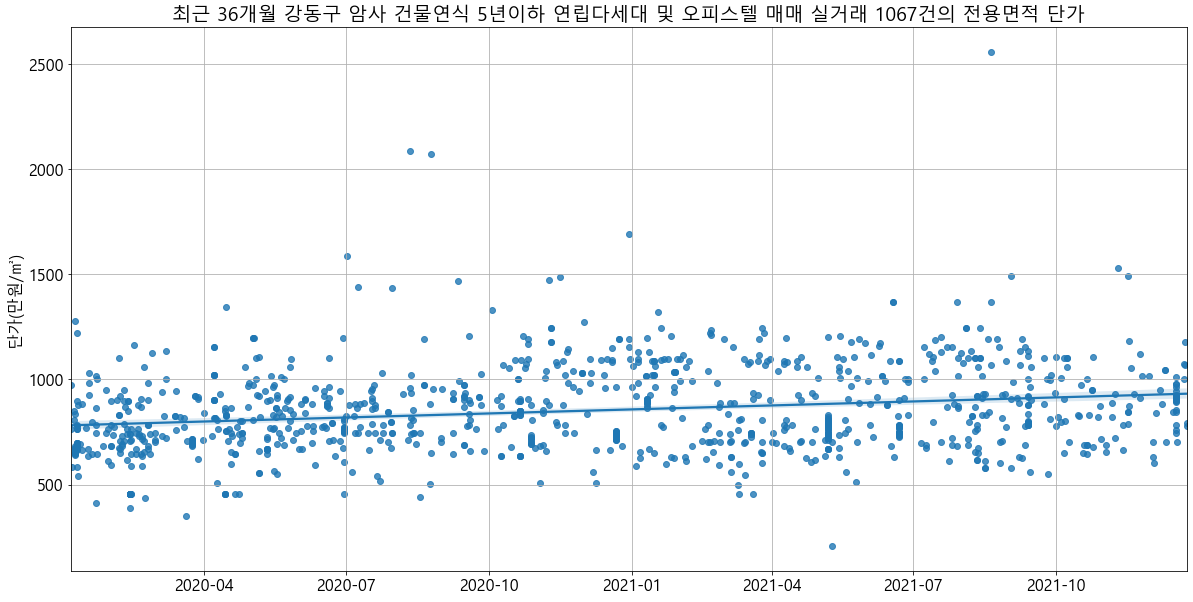

In [52]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 연립다세대 및 오피스텔 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_df['계약날짜']), y=target_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/산포도.png'.format(target_gu, target_dong, date_today_record))

In [53]:
target_last_df = target_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last').reset_index(drop=True)

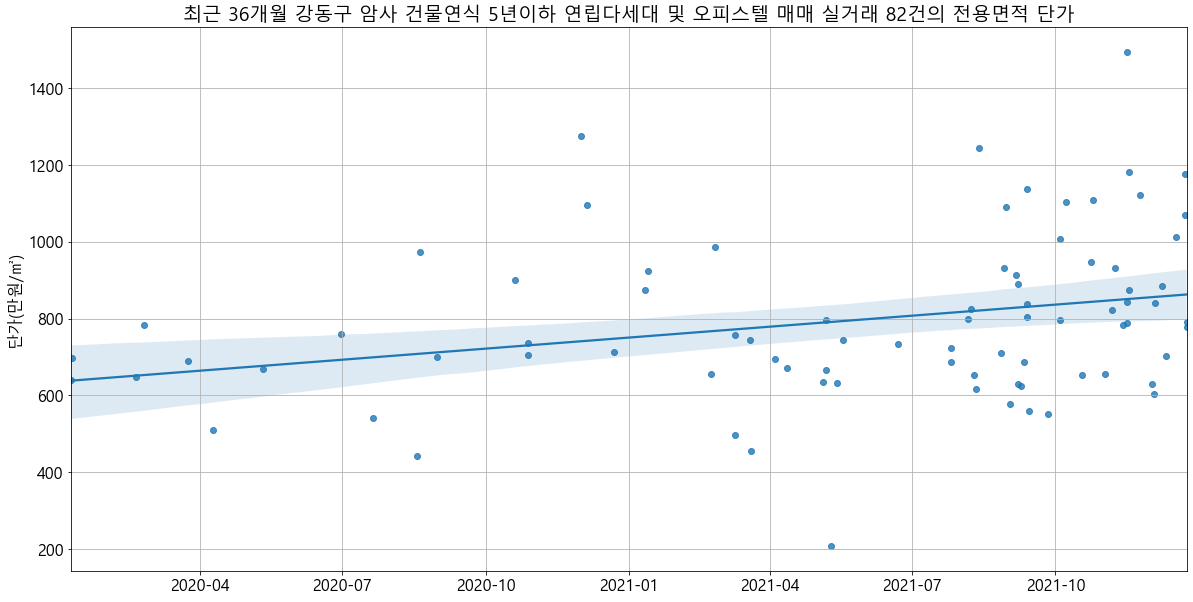

In [54]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 연립다세대 및 오피스텔 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_last_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_last_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_last_df['계약날짜']), y=target_last_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/마지막_산포도.png'.format(target_gu, target_dong, date_today_record))

In [55]:
target_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/마지막_실거래가.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [56]:
target_df2 = house_df[
    (house_df['지번주소'].str.contains(target_gu + ' ' + target_dong))
    #&(house_df['동'] == target_dong)
    #&(house_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_df['계약날짜기준_건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df2.shape)
target_df2.head()

(2901, 26)


,지번주소,도로명,시군구,본번,부번,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래유형,중개사소재지,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,계약기간,계약구분,갱신요구권 사용,종전계약 보증금 (만원),종전계약 월세 (만원),부동산유형,구,동,일괄계약
132033,서울특별시 강동구 암사동 418-22,고덕로 158,서울특별시 강동구 암사동,418.0,22.0,한건토파즈빌,27.40,27000,7,2016.0,NaN,NaN,전세,2.0,2018-09-10,985.401460,6.0,NaN,NaN,NaN,NaN,NaN,연립다세대,강동구,암사동,N
132034,서울특별시 강동구 암사동 418-22,고덕로 158,서울특별시 강동구 암사동,418.0,22.0,한건토파즈빌,27.40,24500,4,2016.0,NaN,NaN,전세,3.0,2019-05-23,894.160584,6.0,NaN,NaN,NaN,NaN,NaN,연립다세대,강동구,암사동,N
132035,서울특별시 강동구 암사동 418-22,고덕로 158,서울특별시 강동구 암사동,418.0,22.0,한건토파즈빌,27.40,27000,7,2016.0,NaN,NaN,전세,4.0,2020-08-03,985.401460,6.0,NaN,NaN,NaN,NaN,NaN,연립다세대,강동구,암사동,N
132036,서울특별시 강동구 암사동 418-22,고덕로 158,서울특별시 강동구 암사동,418.0,22.0,한건토파즈빌,56.10,35000,4,2016.0,NaN,NaN,전세,2.0,2018-06-14,623.885918,6.0,NaN,NaN,NaN,NaN,NaN,연립다세대,강동구,암사동,N
132037,서울특별시 강동구 암사동 418-22,고덕로 158,서울특별시 강동구 암사동,418.0,22.0,한건토파즈빌,58.03,35000,4,2016.0,NaN,NaN,전세,2.0,2018-12-08,603.136309,6.0,NaN,NaN,NaN,NaN,NaN,연립다세대,강동구,암사동,N


In [57]:
target_df2 = get_index_applied_prices(target_df2)

<AxesSubplot:title={'center':'강동구 암사 계약날짜기준 건물연식 5년이하 연립다세대 및 오피스텔 매매 실거래 2901건의 전용면적 단가'}, xlabel='단가(만원/㎡)', ylabel='Count'>

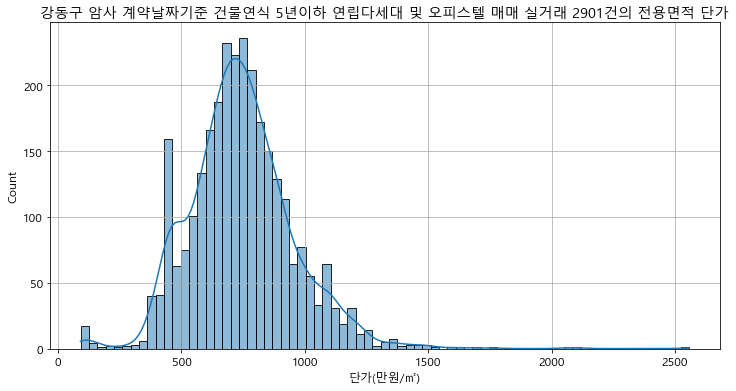

In [58]:
font = {'size': 12}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(12,6))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 연립다세대 및 오피스텔 매매 실거래 {}건의 전용면적 단가'.format(target_gu, target_dong, target_building_age, target_df2.shape[0]))
plt.grid(True)
sns.histplot(target_df2['단가(만원/㎡)'], kde=True)

In [59]:
target_df3 = target_df2[['지번주소', '건물(단지)명', '건축년도', '층', '전용면적(㎡)', '계약날짜', '단가(만원/㎡)', '부동산유형']]
target_df3 = target_df3.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_df3.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/전체_실거래가.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [60]:
target_df3_30 = target_df3[
    (target_df3['전용면적(㎡)'] >= 28)
    &(target_df3['전용면적(㎡)'] <= 32)
]

In [61]:
target_df3_30.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/전체_실거래가_30.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [62]:
concat_df = pd.concat([target_df2])

In [63]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '전용면적(㎡)', '계약날짜']).reset_index(drop=True)
concat_df = concat_df.drop_duplicates(['지번주소', '건축년도', '전용면적(㎡)'], keep='last').reset_index(drop=True)

In [64]:
concat_df['단가평균'] = concat_df[['지번주소', '건축년도', '단가(만원/㎡)']].groupby(['지번주소', '건축년도']).transform('mean')['단가(만원/㎡)']
concat_df['지수적용단가평균'] = concat_df[['지번주소', '건축년도', '지수적용단가']].groupby(['지번주소', '건축년도']).transform('mean')['지수적용단가']

In [65]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '지수적용날짜']).reset_index(drop=True)
print(concat_df.shape)
concat_df.head()

(884, 31)


,지번주소,도로명,시군구,본번,부번,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래유형,중개사소재지,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,계약기간,계약구분,갱신요구권 사용,종전계약 보증금 (만원),종전계약 월세 (만원),부동산유형,구,동,일괄계약,계약날짜_실거래지수,지수적용단가,지수적용날짜,단가평균,지수적용단가평균
0,서울특별시 강동구 암사동 418-22,고덕로 158,서울특별시 강동구 암사동,418.0,22.0,한건토파즈빌,27.40,27000,7,2016.0,NaN,NaN,전세,4.0,2020-08-03,985.401460,6.0,NaN,NaN,NaN,NaN,NaN,연립다세대,강동구,암사동,N,116.075,1164.620157,2021년 10월,737.474562,929.297099
1,서울특별시 강동구 암사동 418-22,고덕로 158,서울특별시 강동구 암사동,418.0,22.0,한건토파즈빌,56.10,35000,4,2016.0,NaN,NaN,전세,2.0,2018-06-14,623.885918,6.0,NaN,NaN,NaN,NaN,NaN,연립다세대,강동구,암사동,N,103.055,830.511994,2021년 10월,737.474562,929.297099
2,서울특별시 강동구 암사동 418-22,고덕로 158,서울특별시 강동구 암사동,418.0,22.0,한건토파즈빌,58.03,35000,4,2016.0,NaN,NaN,전세,2.0,2018-12-08,603.136309,6.0,NaN,NaN,NaN,NaN,NaN,연립다세대,강동구,암사동,N,104.372,792.759147,2021년 10월,737.474562,929.297099
3,서울특별시 강동구 암사동 421-0,암사길 108,서울특별시 강동구 암사동,421.0,0.0,케이집쎄븐,20.51,21000,4,2018.0,NaN,NaN,전세,2.0,2020-09-26,1023.890785,4.0,NaN,NaN,NaN,NaN,NaN,연립다세대,강동구,암사동,N,118.014,1190.227272,2021년 10월,871.391325,1009.286186
4,서울특별시 강동구 암사동 421-0,암사길 108,서울특별시 강동구 암사동,421.0,0.0,케이집쎄븐,22.16,26700,5,2018.0,NaN,NaN,전세,3.0,2021-05-15,1204.873646,4.0,202108~202308,-,-,NaN,NaN,연립다세대,강동구,암사동,N,127.974,1291.604514,2021년 10월,871.391325,1009.286186


In [66]:
concat_last_df = concat_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last')
print(concat_last_df.shape)
concat_last_df.head()

(251, 31)


,지번주소,도로명,시군구,본번,부번,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래유형,중개사소재지,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,계약기간,계약구분,갱신요구권 사용,종전계약 보증금 (만원),종전계약 월세 (만원),부동산유형,구,동,일괄계약,계약날짜_실거래지수,지수적용단가,지수적용날짜,단가평균,지수적용단가평균
2,서울특별시 강동구 암사동 418-22,고덕로 158,서울특별시 강동구 암사동,418.0,22.0,한건토파즈빌,58.03,35000,4,2016.0,NaN,NaN,전세,2.0,2018-12-08,603.136309,6.0,NaN,NaN,NaN,NaN,NaN,연립다세대,강동구,암사동,N,104.372,792.759147,2021년 10월,737.474562,929.297099
9,서울특별시 강동구 암사동 421-0,암사길 108,서울특별시 강동구 암사동,421.0,0.0,케이집쎄븐,29.01,19000,3,2018.0,NaN,NaN,전세,3.0,2021-11-02,654.946570,4.0,-,-,-,NaN,NaN,연립다세대,강동구,암사동,N,지수없음,654.946570,지수없음,871.391325,1009.286186
16,서울특별시 강동구 암사동 421-136,구천면로 365-8,서울특별시 강동구 암사동,421.0,136.0,세림힐하우스,63.98,41800,4,2016.0,-,-,매매,5.0,2021-01-05,653.329165,6.0,NaN,NaN,NaN,NaN,NaN,연립다세대,강동구,암사동,N,122.83,729.688308,2021년 10월,767.361314,892.038437
21,서울특별시 강동구 암사동 421-2,암사길 100,서울특별시 강동구 암사동,421.0,2.0,헤렌하우스,39.38,27300,6,2016.0,NaN,NaN,전세,5.0,2021-10-30,693.245302,6.0,-,-,-,NaN,NaN,연립다세대,강동구,암사동,N,137.186,693.245302,2021년 10월,860.898893,925.127609
22,서울특별시 강동구 암사동 421-24,구천면로 371-3,서울특별시 강동구 암사동,421.0,24.0,미소가,24.51,17000,4,2013.0,NaN,NaN,전세,5.0,2018-04-28,693.594451,9.0,NaN,NaN,NaN,NaN,NaN,연립다세대,강동구,암사동,N,102.007,932.793322,2021년 10월,693.594451,932.793322


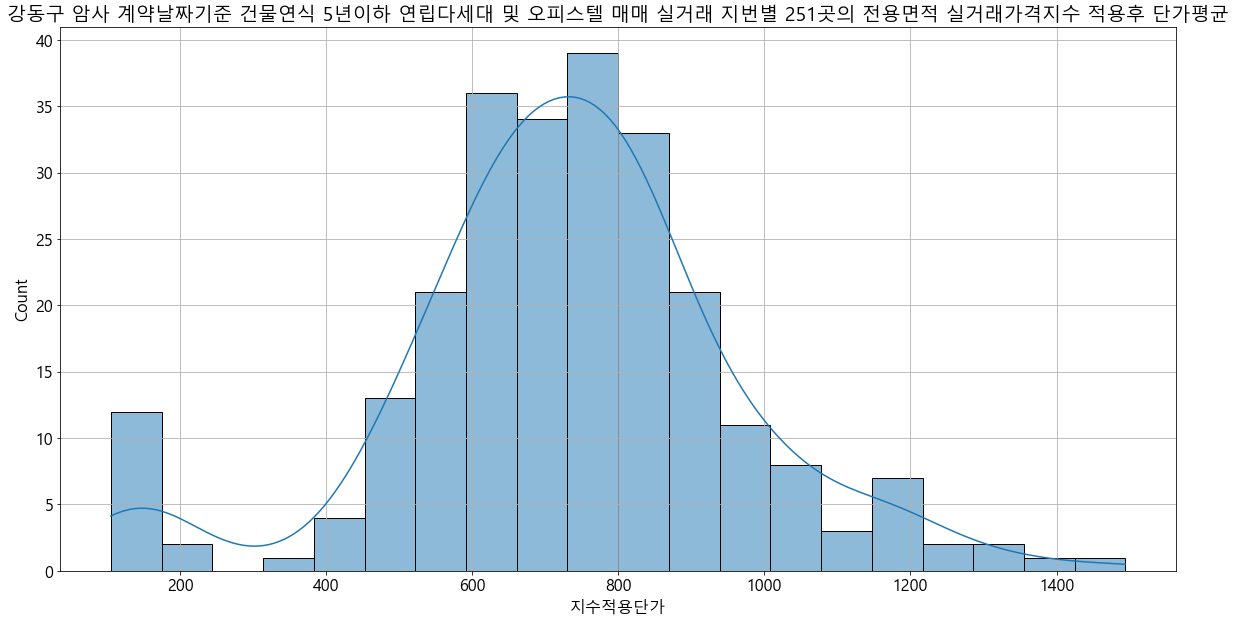

In [67]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 연립다세대 및 오피스텔 매매 실거래 지번별 {}곳의 전용면적 실거래가격지수 적용후 단가평균'.format(target_gu, target_dong, target_building_age, concat_last_df.shape[0]))
plt.grid(True)
sns.histplot(concat_last_df['지수적용단가'], kde=True)
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/지번별_분포도.png'.format(target_gu, target_dong, date_today_record))

In [68]:
concat_last_df = concat_last_df.sort_values(['지번주소']).reset_index(drop=True)

In [69]:
concat_last_df = concat_last_df[['지번주소', '건물(단지)명', '건축년도', '전용면적(㎡)', '층', '계약날짜', '단가(만원/㎡)', '지수적용날짜', '지수적용단가', '부동산유형']]
concat_last_df.rename(columns={'계약날짜':'마지막_계약날짜'}, inplace=True)
concat_last_df.head()

,지번주소,건물(단지)명,건축년도,전용면적(㎡),층,마지막_계약날짜,단가(만원/㎡),지수적용날짜,지수적용단가,부동산유형
0,서울특별시 강동구 암사동 418-22,한건토파즈빌,2016.0,58.03,4,2018-12-08,603.136309,2021년 10월,792.759147,연립다세대
1,서울특별시 강동구 암사동 421-0,케이집쎄븐,2018.0,29.01,3,2021-11-02,654.946570,지수없음,654.946570,연립다세대
2,서울특별시 강동구 암사동 421-136,세림힐하우스,2016.0,63.98,4,2021-01-05,653.329165,2021년 10월,729.688308,연립다세대
3,서울특별시 강동구 암사동 421-2,헤렌하우스,2016.0,39.38,6,2021-10-30,693.245302,2021년 10월,693.245302,연립다세대
4,서울특별시 강동구 암사동 421-24,미소가,2013.0,24.51,4,2018-04-28,693.594451,2021년 10월,932.793322,연립다세대


In [70]:
concat_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/전체_마지막_실거래가.xlsx'.format(target_gu, target_dong, date_today_record), index=False)